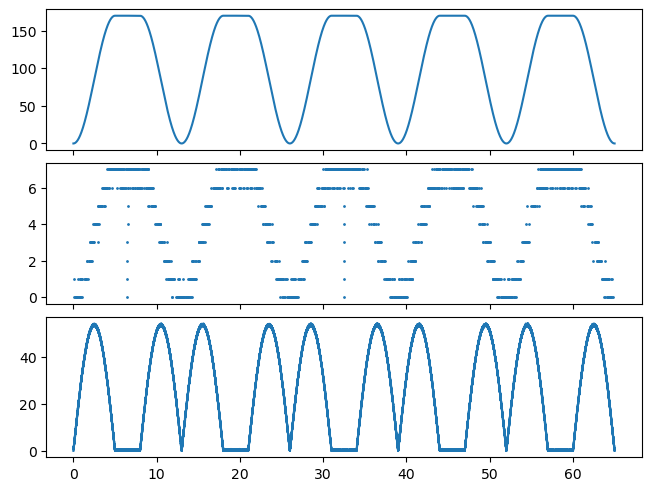

In [1]:
from src.simulate import make_simulated_data
import matplotlib.pyplot as plt
import numpy as np

speed, position, spikes, time, ripple_times, sampling_frequency = make_simulated_data()

fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True)
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, speed)


In [2]:
from replay_trajectory_classification import Environment

is_ripple = speed < 4.0

env = Environment().fit_place_grid(position[:, np.newaxis])

Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/home/edeno/miniconda3/envs/test_hmm/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
true_is_replay = np.zeros_like(speed, dtype=bool)
for ripple_ind, (start_time, end_time) in enumerate(ripple_times):
    if ripple_ind != 1:
        true_is_replay[np.logical_and(time >= start_time, time <= end_time)] = True

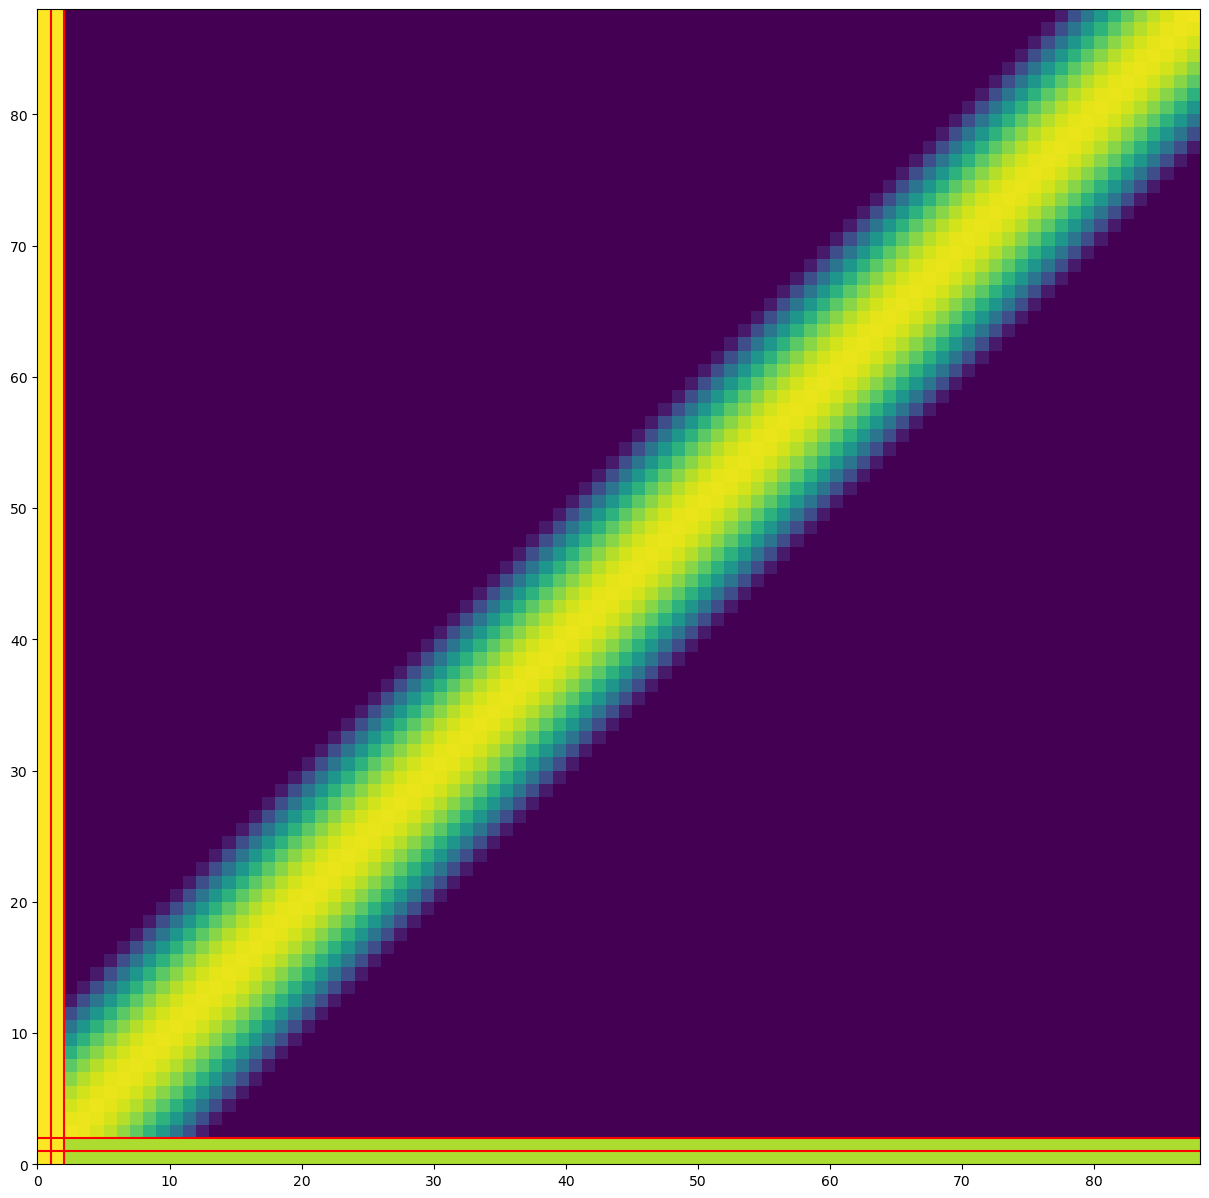

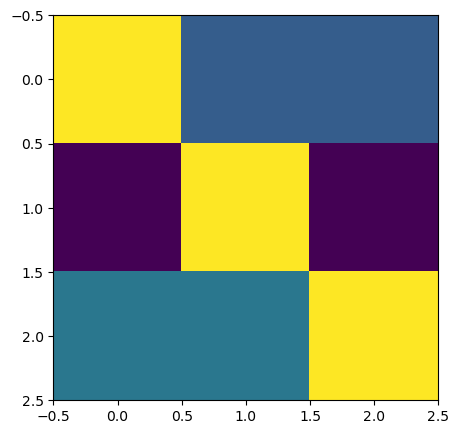

In [4]:
from src.test_non_local_model import setup_nonlocal_switching_model

(
    design_matrix_switching,
    predict_matrix_switching,
    initial_conditions_switching,
    discrete_state_transitions_switching,
    continuous_state_transitions_switching,
    state_ind_switching,
    zero_rates_switching,
    is_training_switching,
    state_names_switching,
) = setup_nonlocal_switching_model(
    is_ripple,
    spikes,
    position,
    env,
)


In [15]:
from src.test_non_local_model import fit_switching_model

(
    predicted_state_switching,
    acausal_posterior_switching,
    acausal_state_probabilities_switching,
    causal_posterior_switching,
    marginal_log_likelihoods_switching,
    initial_conditions_switching,
    discrete_state_transitions_switching,
    coefficients_iter,
    local_rates_iter,
    non_local_rates_iter,
    is_training_iter,
    acausal_posterior_iter,
) = fit_switching_model(
    spikes,
    design_matrix_switching,
    predict_matrix_switching,
    initial_conditions_switching,
    discrete_state_transitions_switching,
    continuous_state_transitions_switching,
    state_ind_switching,
    zero_rates_switching,
    is_training_switching,
    fit_likelihood=False,
    fit_inital_conditions=True,
    fit_discrete_transition=True,
)

Likelihoods


  0%|          | 0/8 [00:00<?, ?it/s]

Expectation Step
Maximization Step
Stats
iteration 1, likelihood: -9675.774457915919
Likelihoods
Expectation Step
Maximization Step
Stats
iteration 2, likelihood: -9511.953204737878, change: 163.82125317804093
Likelihoods
Expectation Step
Maximization Step
Stats
iteration 3, likelihood: -9493.736565947589, change: 18.216638790288926
Likelihoods
Expectation Step
Maximization Step
Stats
iteration 4, likelihood: -9489.077131342538, change: 4.659434605051501
Likelihoods
Expectation Step
Maximization Step
Stats
iteration 5, likelihood: -9488.447120243212, change: 0.6300110993252019


In [85]:
from scipy.stats import multinomial

multinomial.logpmf(x=[0.1, -1], n=1, p=[0.1, 0.9])

array(-inf)

In [25]:
is_ripple

array([ True,  True,  True, ...,  True,  True,  True])

In [111]:
from sklearn.linear_model import LogisticRegression

design_matrix = np.stack((np.ones_like(is_ripple[:-1]), is_ripple[1:]), axis=1).astype(float)

lr = LogisticRegression(penalty=None, fit_intercept=False).fit(design_matrix, is_ripple[1:,].astype(float))

lr.predict_proba([[1, 0],
                  [1, 1]])

array([[9.99999999e-01, 1.08270699e-09],
       [1.38618406e-09, 9.99999999e-01]])

In [112]:
np.logical_and(is_ripple[:-1], is_ripple[1:]).sum() / is_ripple[:-1].sum()

0.9948613720903479

In [113]:
np.logical_and(~is_ripple[:-1], is_ripple[1:]).sum() / (~is_ripple[:-1]).sum()

0.001876172607879925

In [114]:
np.logical_and(is_ripple[:-1], ~is_ripple[1:]).sum() / is_ripple[:-1].sum()

0.005138627909652184

In [115]:
np.logical_and(~is_ripple[:-1], ~is_ripple[1:]).sum()/ (~is_ripple[:-1]).sum()

0.99812382739212

In [ ]:
import jax.numpy as jnp
import jax.scipy.stats
from scipy.optimize import minimize


def fit_multinomial_regression(design_matrix, weights, spikes):
    @jax.jit
    def neglogp(
        coefficients, spikes=spikes, design_matrix=design_matrix, weights=weights
    ):
        conditional_intensity = jnp.exp(design_matrix @ coefficients)
        log_likelihood = weights * jax.scipy.stats.multinomial.logpmf(
            spikes, conditional_intensity
        )
        return -log_likelihood.sum()

    dlike = jax.grad(neglogp)

    initial_condition = np.array([np.log(np.average(spikes, weights=weights))])
    initial_condition = np.concatenate(
        [initial_condition, np.zeros(design_matrix.shape[1] - 1)]
    )

    res = minimize(
        neglogp, x0=initial_condition, method="BFGS", jac=dlike
    )

    return res.x

In [123]:
lr.predict_proba([[1, 1]])[0][1]

0.9999999986138159

In [43]:
from scipy.special import softmax, log_softmax, logsumexp
import numpy as np

def centered_softmax_forward(y):
    """`softmax(x) = exp(x-c) / sum(exp(x-c))` where c is the last coordinate

    Example
    -------
    > y = np.log([2, 3, 4])
    > np.allclose(centered_softmax_forward(y), [0.2, 0.3, 0.4, 0.1])
    """
    if y.ndim == 1:
        y = np.append(y, 0)
    else:
        y = np.column_stack((y, np.zeros((y.shape[0],))))

    return softmax(y, axis=-1)


def centered_log_softmax_forward(y):
    """`softmax(x) = exp(x-c) / sum(exp(x-c))` where c is the last coordinate

    Example
    -------
    > y = np.log([2, 3, 4])
    > np.allclose(centered_softmax_forward(y), [0.2, 0.3, 0.4, 0.1])
    """
    if y.ndim == 1:
        y = np.append(y, 0)
    else:
        y = np.column_stack((y, np.zeros((y.shape[0],))))

    return log_softmax(y, axis=-1)


def centered_softmax_inverse(y):
    """`softmax(x) = exp(x-c) / sum(exp(x-c))` where c is the last coordinate

    Example
    -------
    > y = np.asarray([0.2, 0.3, 0.4, 0.1])
    > np.allclose(np.exp(centered_softmax_inverse(y)), np.asarray([2,3,4]))
    """
    return np.log(y[..., :-1]) - np.log(y[..., -1])

In [46]:
y = np.asarray([0.2, 0.3, 0.4, 0.1])
blah = centered_log_softmax_forward(y)

np.exp(blah[..., :-1] + blah[..., -1] + logsumexp(blah[..., :-1], axis=-1))


array([0.02689773, 0.02972659, 0.03285296, 0.02433807])

In [24]:
centered_softmax_inverse(np.exp(centered_log_softmax_forward(y)))

array([-0.8, -0.7, -0.6, -0.9])

In [19]:
y = np.asarray([0.2, 0.3, 0.4, 0.1])

centered_softmax_inverse(y)

array([0.69314718, 1.09861229, 1.38629436])

In [18]:
centered_softmax_forward(centered_softmax_inverse(y))

array([0.2, 0.3, 0.4, 0.1])

In [ ]:
# exp(x) / sum(exp(x))
# softmax(x) = exp(x-c) / sum(exp(x-c)) where c is the last coordinate
# log_softmax(x) = x - logsumexp(x)

# log_softmax(x - c) = x - c - logsumexp(x - c)
# x = log_softmax(x - c) + c + logsumexp(x - c)
